In [1]:
import sys
import os
import pandas as pd
import re
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
from sklearn.linear_model import LinearRegression
%matplotlib inline


# Data Parsing

In [2]:
# Url with Coffee Consumption Data
coffee_url = 'http://api.viglink.com/api/click?format=go&jsonp=vglnk_14273061108539&key=f6c9fb1ffe086e69e7ff5c6a722caf4c&libId=i7p179n40100pm98000DAdwrfhsuh&loc=http%3A%2F%2Fbackreaction.blogspot.fr%2F2013%2F08%2Fresearchers-and-coffee-consumption.html&v=1&out=http%3A%2F%2Fprime-spot.de%2Fresearcherscoffee.xlsx&ref=http%3A%2F%2Ffreakonometrics.hypotheses.org%2F16010&title=Backreaction%3A%20Researchers%20and%20coffee%20consumption&txt=you%20can%20download%20the%20excel%20sheet%20here'
"""
This Data contains features:
['Country', 'Researchers per million', 'Coffee Consumption']
Gives the size of the group and average consumption of coffee by country
"""

wiki_url = 'http://en.wikipedia.org/wiki/List_of_countries_by_GDP_(PPP)_per_hour_worked'
"""
This Page Contains GDP per Hour Worked by country
"""

'\nThis Page Contains GDP per Hour Worked by country\n'

In [3]:
# Parse wiki_url into panadas DataFrame

from urllib.request import urlopen
page = urlopen(wiki_url)
soup = BeautifulSoup(page.read())

table = soup.find("table", { "class" : "sortable wikitable"})
Ranks = []
Countries = []
GDPS = []

for row in table.findAll("tr"):
    cells = row.findAll("td")
    #For each "tr", assign each "td" to a variable.
    if len(cells) == 3:
        Ranks.append (cells[0].find(text=True))                
        Countries.append(cells[1].find("a", text=True).find(text=True))
        GDPS.append(cells[2].find(text=True)) 
        
table = {'Country' :  Countries,
         'GDP' : GDPS}

df_wiki = pd.DataFrame(table, columns=['Country','GDP'])
df_wiki = df_wiki.convert_objects(convert_numeric='True')
       

In [4]:
# Parse coffee xml
import xlrd

coffe_page = urlopen(coffee_url)
coffe_soup = BeautifulSoup(page.read())

workbook = xlrd.open_workbook('researcherscoffee.xlsx')
worksheet = workbook.sheet_by_name('Sheet1')
num_rows = worksheet.nrows - 1
curr_row = 1
countries_f = []
rpm = []
coffee_cons =[]
while curr_row < num_rows:
    curr_row += 1
    row = worksheet.row(curr_row)
    countries_f.append(row[0].value)
    rpm.append(row[1].value)
    coffee_cons.append(row[2].value)
    
table_xml = {'countries_f' : countries_f,
          'rpm' : rpm,
          'coffee_cons' : coffee_cons}
df_xml = pd.DataFrame(table_xml, columns=['countries_f', 'rpm', 'coffee_cons'])
df_xml = df_xml[df_xml.coffee_cons != '']
df_xml = df_xml.convert_objects(convert_numeric='True')



# data analysis

one issue we can see here is that 53 countries have rpm (researchers per million)  < 360
In a population of 1 million we need at least 384 samples to be able to have a confidence level of 95% in the results (with margin error of 5%) 
As we can see, in many countries the sample size is much smaller, thus the accuracy of the results (the coffee consumption number)  in those countries is questionable. 

In [5]:
small_rpm = df_xml[df_xml['rpm'] < 384]
small_rpm.count()

countries_f    53
rpm            53
coffee_cons    53
dtype: int64

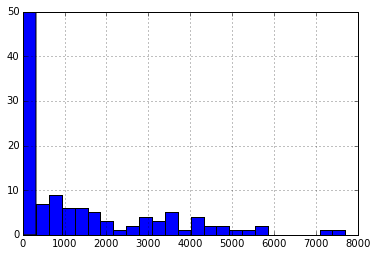

In [6]:
df_xml['rpm'].hist(bins=25)

## combined data 

In [7]:
combined = pd.merge(df_wiki, df_xml,left_on='Country', right_on='countries_f', how='inner')
combined = combined[['Country','GDP','rpm','coffee_cons']]
combined.head()

,Country,GDP,rpm,coffee_cons
0,Norway,75.18,5468,9.9
1,Luxembourg,73.22,4748,6.8
2,Belgium,60.98,3435,6.8
3,Netherlands,60.06,3089,8.4
4,France,59.24,3496,5.4


###  lets remove from the table the countries with rpm < 300, which as we said may be unreliable

In [35]:
combined = combined[combined['rpm'] > 300]

In [36]:
combined.corr()

,GDP,rpm,coffee_cons
GDP,1.000000,0.730547,0.716953
rpm,0.730547,1.000000,0.805556
coffee_cons,0.716953,0.805556,1.000000


In [41]:
X = combined['GDP'].values
Y = combined['coffee_cons'].values
X = X.reshape(43,1)

In [42]:
model = LinearRegression()
model.fit(X,Y)
y_line = model.predict(X)

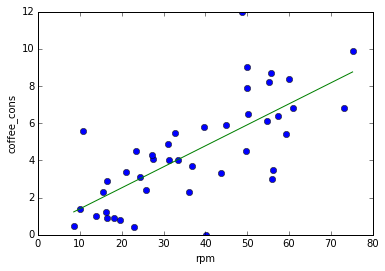

In [43]:
plt.plot(X, Y, 'o')
plt.plot(X, y_line)
plt.xlabel('rpm')
plt.ylabel('coffee_cons')


In [44]:
model.score(X,Y)

0.51402219437781094

In [45]:
import statsmodels.api as sm
X = sm.add_constant(X)
model = sm.OLS(Y,X)


In [46]:
results = model.fit()

In [47]:
print (results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     43.37
Date:                Sun, 10 May 2015   Prob (F-statistic):           6.37e-08
Time:                        12:55:14   Log-Likelihood:                -90.119
No. Observations:                  43   AIC:                             184.2
Df Residuals:                      41   BIC:                             187.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.2664      0.708      0.376      0.7

## conclusion 
From the combined data we can see that there is a positive correlation between a country GDP
and its coffee consumption. 
We can see this correlation from both the graph, and the P value of the x1 coefficient, which is 0.

